In [11]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
# Loading the labelled data
df = pd.read_csv('/Users/diegolemos/Masters/ML/CA2/labelled_data_final.csv')

# Checking the file
df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,conversation_id,message_length,clean_text,vader_sentiment,distilbert_sentiment,roberta_sentiment,final_label
0,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,1.0,45,and how do you propose we do that,neutral,positive,neutral,neutral
1,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,4.0,82,i have sent several private messages and no on...,negative,negative,negative,negative
2,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,6.0,18,i did,neutral,positive,neutral,neutral
3,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,8.0,41,is the worst customer service,negative,negative,negative,negative
4,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15.0,15.0,89,you gonna magically change your connectivity f...,neutral,positive,neutral,neutral


In [3]:
# Checking final_label count
df['final_label'].value_counts()

final_label
negative    797863
positive    424513
neutral     315467
Name: count, dtype: int64

In [4]:
# Train, test and split data
X = df['clean_text']
y = df['final_label']

# Using stratify for balanced classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42) 

In [5]:
# Dropping NaN values in clean_text before vectorization
# For training
train_df = pd.DataFrame({'text': X_train, 'label': y_train})
train_df = train_df.dropna(subset=['text'])

X_train = train_df['text']
y_train = train_df['label']

# For testing
test_df = pd.DataFrame({'text': X_test, 'label': y_test})
test_df = test_df.dropna(subset=['text'])

X_test = test_df['text']
y_test = test_df['label']

In [6]:
# Creating TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features = 5000, ngram_range = (1, 2))

# Fit on train
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [13]:
# Deploying SVM
svm = LinearSVC(class_weight='balanced')
svm.fit(X_train_tfidf, y_train)
svm_preds = svm.predict(X_test_tfidf)

print('SVM Classification Report: ')
print(classification_report(y_test, svm_preds))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


SVM Classification Report: 
              precision    recall  f1-score   support

    negative       0.90      0.85      0.87    159573
     neutral       0.75      0.90      0.82     59184
    positive       0.84      0.80      0.82     84903

    accuracy                           0.85    303660
   macro avg       0.83      0.85      0.84    303660
weighted avg       0.85      0.85      0.85    303660



In [14]:
# Deploying Random Forest
rf = RandomForestClassifier(n_estimators = 100, max_depth = 40, class_weight='balanced', random_state = 42)
rf.fit(X_train_tfidf, y_train)
rf_preds = rf.predict((X_test_tfidf))

print('Random Forest Classification Report: ')
print(classification_report(y_test, rf_preds))

Random Forest Classification Report: 
              precision    recall  f1-score   support

    negative       0.81      0.78      0.80    159573
     neutral       0.54      0.82      0.65     59184
    positive       0.82      0.59      0.69     84903

    accuracy                           0.73    303660
   macro avg       0.72      0.73      0.71    303660
weighted avg       0.76      0.73      0.74    303660



#### Comparing Models

In [15]:
# Summary table of ML models
model_comparison = pd.DataFrame({
    'Model': ['SVM (Balanced)', 'Random Forest (Balanced)'],
    'Accuracy': [0.85, 0.73],
    'Macro Avg F1': [0.84, 0.71],
    'Weighted Avg F1': [0.85, 0.74],
    'Macro Avg Precision': [0.83, 0.72],
    'Macro Avg Recall': [0.85, 0.73]
})

model_comparison

,Model,Accuracy,Macro Avg F1,Weighted Avg F1,Macro Avg Precision,Macro Avg Recall
0,SVM (Balanced),0.85,0.84,0.85,0.83,0.85
1,Random Forest (Balanced),0.73,0.71,0.74,0.72,0.73


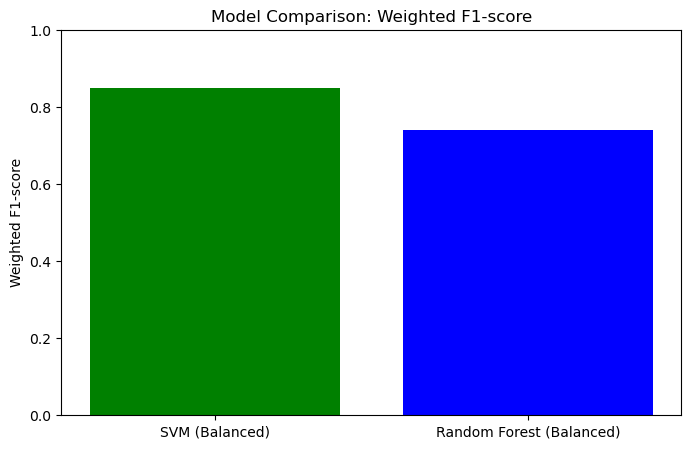

In [16]:
# Plotting F1-score for comparison
plt.figure(figsize=(8,5))
plt.bar(model_comparison['Model'], model_comparison['Weighted Avg F1'], color=['green', 'blue'])
plt.ylabel('Weighted F1-score')
plt.title('Model Comparison: Weighted F1-score')
plt.ylim(0, 1)
plt.show()

#### Machine Learning Model Evaluation Summary
Two traditional machine learning models were trained and evaluate, Linear SVM and Random Forest. Both models were trained with class weighting to address class imbalance in the sentiment dataset.

Due to time and computational constraints, SMOTE was not applied. Instead, class weights were considered for handling class imbalance.

##### Results Overview:
- SVM with "class_weight='balanced'" achieved an overall accuracy of 85% and a macro F1-score of 0.84, making it the best performer. The SVM model maintained high precision and recall across all three sentiment classes, demonstrating robust performance even with imbalanced data.

- Random Forest with max_depth = 40, class_weight='balanced' achieved an accuracy of 73% and a macro F1-score of 0.71. While recall for the negative class was high, the model continued to underperform on the neutral and positive classes compared to SVM, despite the use of class weighting.
  
##### Insights:
- Using class weighting improved the balance of recall and precision, especially for the minority classes neutral and positive, but SVM consistently provided the most stable and balanced results across all metrics.

- Random Forest, although improved with class weighting, still lagged behind SVM, particularly in precision for the neutral class, and showed signs of difficulty generalizing across all classes.

##### Conclusion:
- SVM with class weighting is the preferred traditional machine learning model for this task, based on both performance and efficiency.

- The updated results confirm that addressing class imbalance is essential for fair evaluation.

- These results will serve as the main benchmark for comparison as we move forward to developing and evaluating deep learning models.
